In [1]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 561.4 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=eb508f1f684375a6b8ecc881c80018a5426bc6e3885efecdb6938181311aacc8
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizerFast, BertModel, AdamW, BertConfig, BertPreTrainedModel, BertForTokenClassification
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm

import warnings
from transformers import logging

warnings.simplefilter(action='ignore', category=FutureWarning)
logging.set_verbosity_error()

In [3]:
config = {}
config['MAX_LEN'] = 100
# config['datasplit'] = 0.8
config['batch_size'] = 32
config['epochs'] = 20
config['lr'] = 1e-3
config['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# train annotated
dict_train = {
        'word': [],
        'annotated': [],
        'sentence': [],
    }
with open( 'train_data.txt', 'r', encoding='UTF-8') as f:
    lines = f.readlines()
    for items in lines:
        items = re.sub('\n', '',items)
        record = items.split('\t')
        dict_train['word'].append(record[0])
        dict_train['sentence'].append(record[1])
        dict_train['annotated'].append(record[2])
df_train = pd.DataFrame(dict_train)

# test annotated
dict_test = {
        'word': [],
        'annotated': [],
        'sentence': [],
    }
with open( 'test_data.txt', 'r', encoding='UTF-8') as f:
    lines = f.readlines()
    for items in lines:
        items = re.sub('\n', '',items)
        record = items.split('\t')
        dict_test['word'].append(record[0])
        dict_test['sentence'].append(record[1])
        dict_test['annotated'].append(record[2])
df_test = pd.DataFrame(dict_test)

train sentence length
train size: 6362


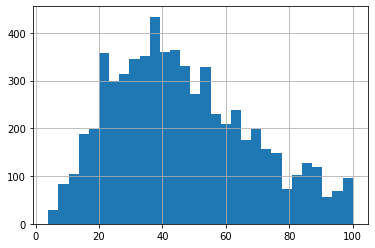

In [5]:
train_sent_len = [len(i) for i in df_train['sentence']]
pd.Series(train_sent_len).hist(bins = 30)
print("train sentence length")
print("train size:", len(df_train['sentence']))

test sentence length
test size: 7827


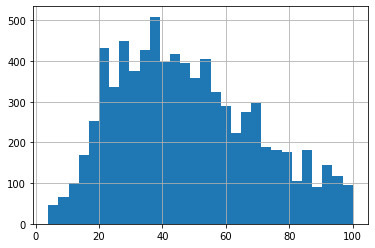

In [6]:
test_sent_len = [len(i) for i in df_test['sentence']] # df_test_article['content'][73] == Nan
pd.Series(test_sent_len).hist(bins = 30)
print("test sentence length")
print("test size:", len(df_test['sentence']))

In [7]:
df_train

,word,annotated,sentence
0,应届毕业生,General,中国公司每年会提供专门面向应届毕业生的岗位，一旦过了这个窗口，毕业生就得通过社会招聘的渠道找...
1,灵活就业,Labor,数据显示，26.9%的劳动者出于“到手收入相对较高”选择灵活就业，18.7%的劳动者为了“正...
2,是否会,O,针对人们对近期阶段性实施缓缴社保费政策是否会影响职工权益的关切，人社部失业保险司司长桂桢回应...
3,灵活就业,Labor,直播间里的灵活就业
4,半个月,O,4月份头半个月，郑明和一辆破旧的电瓶车相依为命
...,...,...,...
6357,灵活就业,Labor,但灵活就业也挑战了传统雇佣模式，固化了工人的职业路径，出现了劳动保障缺失等问题
6358,打工人,Labor,年营收超千亿、中国最大的动力电池大厂为何不招未婚打工人
6359,试点区县,General,（责任单位：市质量总站、市安管总站，各试点区县）（三）提升自有工人技能水平1．提高职工教育经...
6360,Ifeng电影,Name,Ifeng电影统计，2022年待映片只有111部，每周平均3.8部，其中已定档（还没撤的）4...


# Data preprocessing

In [8]:
print('==== Loading BertTokenizerFast ====')
model_name = "hfl/chinese-bert-wwm-ext"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

==== Loading BertTokenizerFast ====


Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [9]:
def form_labels(df):

    input_ids = []
    input_masks = []
    matched_words = []    
    label = []
    # unmatched_counter = 0
    
    for idx in tqdm(range(len(df['sentence']))):    
        encoded_text = tokenizer.encode_plus(
            df.iloc[idx, 2],
            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
            max_length = config['MAX_LEN'],
            pad_to_max_length =True,
            return_token_type_ids = False,
            return_attention_mask = True,
        )
        tokens = encoded_text.get('input_ids')
        input_ids.append(tokens)
        input_masks.append(encoded_text.get('attention_mask'))
        
        z = np.array(['O-O'] * len(tokens)) # Create final label == len(tokens) of each sentence
        z[:] = 'O'
        
        matched_keywords = 0 # Initially no kword matched    
        
        if(df.iloc[idx, 1] == 'O'): # no need to annotate, but we add to matched_words
            
            matched_keywords += 1
            if matched_keywords >1:
                label[-1] = (z.tolist())
                matched_words[-1].append(df.iloc[idx, 0])
            else:
                label.append(z.tolist())
                matched_words.append([df.iloc[idx, 0]])
    
        else:
            encoded_word = tokenizer.encode_plus(
                df.iloc[idx, 0],
                add_special_tokens = False, # Add '[CLS]' and '[SEP]'
                return_token_type_ids = False,
                return_attention_mask = False,
            )
            word_tokens = encoded_word.get('input_ids')

            for i in range(len(tokens)):
                if tokens[i: (i + len(word_tokens))] == word_tokens:
                    
                    matched_keywords += 1
                    
                    if (len(word_tokens) == 1):
                        # z[i] = 'B'
                        z[i] = 'B-' + df.iloc[idx, 1][0]
                    else:
                        z[i] = 'B-' + df.iloc[idx, 1][0]
                        z[(i+1) : (i+ len(word_tokens))] = 'I-' + df.iloc[idx, 1][0]
                        
                    if matched_keywords >1:
                        label[-1] = (z.tolist())
                        matched_words[-1].append(df.iloc[idx, 0])
                    else:
                        label.append(z.tolist())
                        matched_words.append([df.iloc[idx, 0]])
                        
    return input_ids, input_masks, matched_words, label

In [10]:
train_ids, train_masks, train_matchedwords, train_labels = form_labels(df_train)
test_ids, test_masks, test_matchedwords, test_labels = form_labels(df_test)

100%|██████████| 7827/7827 [00:04<00:00, 1597.63it/s]


# Showing data after labeling

In [11]:
# show training data
train_df = pd.DataFrame({'sentences': df_train['sentence'], 
                        'word': train_matchedwords, 
                        'label':train_labels})
train_df

,sentences,word,label
0,中国公司每年会提供专门面向应届毕业生的岗位，一旦过了这个窗口，毕业生就得通过社会招聘的渠道找...,[应届毕业生],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-G..."
1,数据显示，26.9%的劳动者出于“到手收入相对较高”选择灵活就业，18.7%的劳动者为了“正...,[灵活就业],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,针对人们对近期阶段性实施缓缴社保费政策是否会影响职工权益的关切，人社部失业保险司司长桂桢回应...,[是否会],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,直播间里的灵活就业,[灵活就业],"[O, O, O, O, O, O, B-L, I-L, I-L, I-L, O, O, O..."
4,4月份头半个月，郑明和一辆破旧的电瓶车相依为命,[半个月],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
6357,但灵活就业也挑战了传统雇佣模式，固化了工人的职业路径，出现了劳动保障缺失等问题,[灵活就业],"[O, O, B-L, I-L, I-L, I-L, O, O, O, O, O, O, O..."
6358,年营收超千亿、中国最大的动力电池大厂为何不招未婚打工人,[打工人],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6359,（责任单位：市质量总站、市安管总站，各试点区县）（三）提升自有工人技能水平1．提高职工教育经...,[试点区县],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
6360,Ifeng电影统计，2022年待映片只有111部，每周平均3.8部，其中已定档（还没撤的）4...,[Ifeng电影],"[O, B-N, I-N, I-N, I-N, O, O, O, O, O, O, O, O..."


In [12]:
# show testing data
test_df = pd.DataFrame({'sentences': df_test['sentence'], 
                        'word': test_matchedwords, 
                        'label':test_labels})
test_df

,sentences,word,label
0,另外，还有一个比较矛盾的地方：在这次的职业教育法里，提到很多关于培训的认证，但是我们知道，现...,[劳动力市场],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,但弊端在于，普通人对于隔着网络的诊疗很难完全信任，医生本着谨慎求真的心态也会倾向于与患者真切见面,[倾向于],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,学人说丨育儿中的数字化劳动：隐形的夫妻分工不平等,[育儿中],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,从北蔡镇到宝山区，全程约38公里，每人300元,[北蔡镇],"[O, O, B-N, I-N, I-N, O, O, O, O, O, O, O, O, ..."
4,如果说闭环员工的生活是稳定憋闷的“圈内活动”，那能在外面跑的保供企业员工的生活就是紧张持续的...,[保供企业],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
7822,本案对推动用人单位依法保障劳动者获取劳动报酬具有积极意义,[保障劳动者],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7823,当大量员工被封闭在家，生产的巨大压力就集中在少数人、少数企业身上,[被封闭],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
7824,与工人新村基层妇女们贯穿多年的访谈、交流，使叶子婷、章羽、刘希等学者和学生组成的研究团队受益...,[基层妇女],"[O, O, O, O, O, O, B-G, I-G, I-G, I-G, O, O, O..."
7825,实际上，他们是上海本轮新冠疫情防控的“打工人”，通过保安公司、中介招聘来的“防疫保安”,[疫情防控],"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-G..."


In [13]:
tags_2_idx = {'O': 0 , 'B-G': 1, 'I-G': 2, 'B-L':3, 'I-L': 4, 'B-N':5, 'I-N':6 }
idx_2_tags = {v: k for k, v in tags_2_idx.items()}
label_class_name = ['General', 'Labor', 'Name']
train_labels_id = [list(map(tags_2_idx.get, lab)) for lab in train_labels]
test_labels_id = [list(map(tags_2_idx.get, lab)) for lab in test_labels]

In [14]:
train_data = TensorDataset(torch.tensor(train_ids), torch.tensor(train_masks), torch.tensor(train_labels_id))
train_dataloader = DataLoader(train_data, batch_size = config['batch_size'])
test_data = TensorDataset(torch.tensor(test_ids), torch.tensor(test_masks), torch.tensor(test_labels_id))
test_dataloader = DataLoader(test_data, batch_size = config['batch_size'])

# Reweight Class

In [15]:
import itertools
from collections import Counter

counter = Counter(i for i in list(itertools.chain.from_iterable(train_labels_id)))
print(counter)
max_val = float(max(counter.values())) 
class_weights_dic = {class_id : (max_val/num) for class_id, num in counter.items()} 

sorted_items = sorted(class_weights_dic.items()) # Get key-value pairs and Sort dictionary by key
class_weights_dict = {class_id : weight for class_id, weight in sorted_items}
print(class_weights_dict)

Counter({0: 620395, 4: 5329, 2: 5309, 1: 1818, 3: 1738, 6: 1122, 5: 489})
{0: 1.0, 1: 341.2513751375138, 2: 116.8572235825956, 3: 356.95914844649025, 4: 116.41865265528241, 5: 1268.7014314928426, 6: 552.9367201426024}


In [16]:
# class_weights = [ 1, 120, 120, 120, 120, 550, 550]
class_weights = [ 0.1, 120, 120, 120, 120, 550, 550]
class_weights = torch.tensor(class_weights,dtype=torch.float).to(config['device'])

## Model

In [17]:
class BertSeqTagging(BertPreTrainedModel):
    def __init__(self, config, num_class):
        super().__init__(config)
        self.num_labels = num_class
        self.bert = BertModel.from_pretrained(       
            'hfl/chinese-bert-wwm-ext',
            num_labels = num_class,
            output_attentions = False,
            add_pooling_layer=False,
        )
        
        # 鎖定預訓練模型參數
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.config = self.bert.config
        self.dropout = nn.Dropout(self.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_class)      
        self.loss_weight = class_weights
        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )        
        # outputs[0] => outputs.last_hidden_state
        # outputs[1] => outputs.pooler_output # if add_pooling_layer = True
        sequence_output = outputs.last_hidden_state # outputs[0]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here
        if labels is not None:
            loss_fct = CrossEntropyLoss(weight = class_weights)
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs

In [18]:
def train_loop(model, dataloader, optimizer):       
    model.train() # Set our model to training mode (as opposed to evaluation mode)
    total_loss = 0 # Reset total loss for this epoch.
    #total_acc = 0
    pred_labels_id = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])
    true_labels_id = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])
        
    with tqdm(dataloader, unit='batch', desc='Train') as tqdm_loader: # desc: Prefix for the progressbar.                  
        for step, batch in enumerate(tqdm_loader):                               
            batch = tuple(t.to(device = config['device']) for t in batch) # Add batch to GPU
            input_ids, input_mask, labels = batch # Unpack the inputs from our dataloader
            # Clear out the gradients (by default they accumulate) 
            optimizer.zero_grad()                
            outputs = model(input_ids, token_type_ids=None, attention_mask = input_mask, labels = labels) # Forward pass for multilabel classification
            loss = outputs[0]
            pred = outputs[1] # torch.Size([batch_size, seq_length, num_class])
            # Compute gradients and update weights
            loss.backward() # Backward pass # 計算梯度
            optimizer.step()  # Update parameters and take a step using the computed gradient (call .step() to initiate gradient descent)          
            # Update tracking variables
            # 1. loss
            now_loss = loss.item() # 同loss.detach().item()
            total_loss += now_loss
            # 2. accuracy
            predictions = np.argmax(pred.detach().to('cpu').numpy(), axis = 2)
            actual = labels.to('cpu').numpy()
            #acc = accuracy_score([list(map(idx_2_tags.get, lab)) for lab in actual], [list(map(idx_2_tags.get, lab)) for lab in predictions])
            #total_acc += acc
            pred_labels_id = np.concatenate((pred_labels_id, predictions), axis = 0)
            true_labels_id = np.concatenate((true_labels_id, actual), axis = 0)
            tqdm_loader.set_postfix( {'avg_loss':f'{total_loss/(step+1):.4f}'}) # ,'avg_acc':f'{total_acc/(step+1):.4f}'
    # convert back to BIO
    pred_labels = [list(map(idx_2_tags.get, lab)) for lab in pred_labels_id]
    true_labels = [list(map(idx_2_tags.get, lab)) for lab in true_labels_id]
    # performance & metrics 
    avg_loss = total_loss / len(dataloader) # len(train_dataloader) == total step number
    avg_acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, zero_division = 1)
    recall = recall_score(true_labels, pred_labels, zero_division = 1)        
    f1 = f1_score(true_labels, pred_labels, zero_division = 1)
    # macro_f1 = f1_score(true_labels, pred_labels, average='macro')
    # micro_f1 = f1_score(true_labels, pred_labels, average='micro')
    # weighted_f1 = f1_score(true_labels, pred_labels, average='weighted')
    print(f"  Average training loss: {avg_loss:.4f}")
    print(f"  Training Accuracy:     {avg_acc:.4f}" )
    print(f"  Training Precision:    {precision:.4f}" )
    print(f"  Training Recall:       {recall:.4f}" )
    print(f"  Training F1-score:     {f1:.4f}" )
    print('  Each class F1:', ''.join('{}: {:.4f} '.format(*k) for k in enumerate( f1_score(true_labels, pred_labels, average = None, zero_division = 1) )) )
    return avg_loss, f1

In [19]:
@torch.no_grad()
def test_loop(model, dataloader, optimizer, report = False):
    model.eval()
    total_loss = 0
    #total_acc = 0
    pred_labels_id = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])
    true_labels_id = np.array([], dtype = np.int64).reshape(0, config['MAX_LEN'])

    with torch.no_grad():
        with tqdm(dataloader, unit='batch', desc='Test') as tqdm_loader:
            for step, batch in enumerate(tqdm_loader):
                batch = tuple(t.to(device = config['device']) for t in batch) # Add batch to GPU
                input_ids, input_mask, labels = batch # Unpack the inputs from our dataloader  
                outputs = model(input_ids, token_type_ids=None, attention_mask = input_mask, labels = labels)
                loss, pred = outputs[0], outputs[1]                            
                # Update tracking variables
                # 1. loss            
                now_loss = loss.item()
                total_loss += now_loss
                # 2. accuracy
                predictions = np.argmax(pred.detach().to('cpu').numpy(), axis = 2)
                actual = labels.to('cpu').numpy()
                # acc = accuracy_score([list(map(idx_2_tags.get, lab)) for lab in actual], [list(map(idx_2_tags.get, lab)) for lab in predictions])
                # total_acc += acc
                pred_labels_id = np.concatenate((pred_labels_id, predictions), axis = 0)
                true_labels_id = np.concatenate((true_labels_id, actual), axis = 0)
                    
                tqdm_loader.set_postfix({'avg_loss':f'{total_loss/(step+1):.4f}'}) # ,'avg_acc':f'{total_acc/(step+1):.4f}' 
    # convert back to BIO
    pred_labels = [list(map(idx_2_tags.get, lab)) for lab in pred_labels_id]
    true_labels = [list(map(idx_2_tags.get, lab)) for lab in true_labels_id]
    # performance & metrics 
    avg_loss = total_loss / len(dataloader)    
    avg_acc = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, zero_division = 1)
    recall = recall_score(true_labels, pred_labels, zero_division = 1)        
    f1 = f1_score(true_labels, pred_labels, zero_division = 1)
    print(f"  Average training loss: {avg_loss:.4f}")
    print(f"  Testing Accuracy:     {avg_acc:.4f}" )
    print(f"  Testing Precision:    {precision:.4f}" )
    print(f"  Testing Recall:       {recall:.4f}" )
    print(f"  Testing F1-score:     {f1:.4f}" )
    print('  Each class F1:', ''.join('{}: {:.4f} '.format(*k) for k in enumerate( f1_score(true_labels, pred_labels, average = None, zero_division = 1) )) )
    if(report == True):
        print(classification_report(true_labels, pred_labels))
    return avg_loss, f1

In [20]:
model = BertSeqTagging(BertConfig(), num_class = len(tags_2_idx))
model = model.to(config['device'])
# optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = config['lr'])
optimizer = torch.optim.AdamW(model.parameters(), lr = config['lr'])

Downloading:   0%|          | 0.00/393M [00:00<?, ?B/s]

In [21]:
# optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = config['lr'])

# Training

In [22]:
train_history = { 'loss':[], 'f1': [], 'val_loss':[], 'val_f1': [] }
epochs = config['epochs']

for epoch in range(epochs):
    print('============= Epoch {:} / {:} =============\n'.format(epoch + 1, epochs))
    #if((epoch+1) % 5 == 0):        
    #    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.1
    print("LR =", optimizer.param_groups[0]['lr'])
    train_loss, train_f1 = train_loop(model, train_dataloader, optimizer)
    train_history.get('loss').append(train_loss)
    train_history.get('f1').append(train_f1)
#     test_loss, test_f1 = test_loop(model, test_dataloader, optimizer)
#     train_history.get('val_loss').append(test_loss)
#     train_history.get('val_f1').append(test_f1)
    print("")

============= Epoch 1 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:20<00:00,  9.56batch/s, avg_loss=1.5153]


  Average training loss: 1.5153
  Training Accuracy:     0.0127
  Training Precision:    0.0005
  Training Recall:       0.0467
  Training F1-score:     0.0011
  Each class F1: 0: 0.0008 1: 0.0011 2: 0.0014 

============= Epoch 2 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00,  9.97batch/s, avg_loss=1.2863]


  Average training loss: 1.2863
  Training Accuracy:     0.0140
  Training Precision:    0.0009
  Training Recall:       0.0803
  Training F1-score:     0.0017
  Each class F1: 0: 0.0009 1: 0.0022 2: 0.0023 

============= Epoch 3 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.02batch/s, avg_loss=1.2128]


  Average training loss: 1.2128
  Training Accuracy:     0.0239
  Training Precision:    0.0011
  Training Recall:       0.1033
  Training F1-score:     0.0022
  Each class F1: 0: 0.0011 1: 0.0030 2: 0.0027 

============= Epoch 4 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.00batch/s, avg_loss=1.1735]


  Average training loss: 1.1735
  Training Accuracy:     0.0323
  Training Precision:    0.0012
  Training Recall:       0.1130
  Training F1-score:     0.0024
  Each class F1: 0: 0.0011 1: 0.0034 2: 0.0030 

============= Epoch 5 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.02batch/s, avg_loss=1.1547]


  Average training loss: 1.1547
  Training Accuracy:     0.0383
  Training Precision:    0.0012
  Training Recall:       0.1189
  Training F1-score:     0.0025
  Each class F1: 0: 0.0012 1: 0.0034 2: 0.0032 

============= Epoch 6 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.04batch/s, avg_loss=1.1408]


  Average training loss: 1.1408
  Training Accuracy:     0.0416
  Training Precision:    0.0012
  Training Recall:       0.1174
  Training F1-score:     0.0024
  Each class F1: 0: 0.0014 1: 0.0032 2: 0.0029 

============= Epoch 7 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.02batch/s, avg_loss=1.1234]


  Average training loss: 1.1234
  Training Accuracy:     0.0427
  Training Precision:    0.0013
  Training Recall:       0.1236
  Training F1-score:     0.0026
  Each class F1: 0: 0.0014 1: 0.0035 2: 0.0031 

============= Epoch 8 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.01batch/s, avg_loss=1.1212]


  Average training loss: 1.1212
  Training Accuracy:     0.0432
  Training Precision:    0.0013
  Training Recall:       0.1241
  Training F1-score:     0.0025
  Each class F1: 0: 0.0016 1: 0.0032 2: 0.0032 

============= Epoch 9 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00,  9.95batch/s, avg_loss=1.1040]


  Average training loss: 1.1040
  Training Accuracy:     0.0446
  Training Precision:    0.0013
  Training Recall:       0.1248
  Training F1-score:     0.0026
  Each class F1: 0: 0.0015 1: 0.0035 2: 0.0030 

============= Epoch 10 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:20<00:00,  9.93batch/s, avg_loss=1.1190]


  Average training loss: 1.1190
  Training Accuracy:     0.0456
  Training Precision:    0.0013
  Training Recall:       0.1244
  Training F1-score:     0.0025
  Each class F1: 0: 0.0015 1: 0.0032 2: 0.0032 

============= Epoch 11 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00,  9.97batch/s, avg_loss=1.1103]


  Average training loss: 1.1103
  Training Accuracy:     0.0463
  Training Precision:    0.0013
  Training Recall:       0.1278
  Training F1-score:     0.0026
  Each class F1: 0: 0.0015 1: 0.0034 2: 0.0033 

============= Epoch 12 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00,  9.98batch/s, avg_loss=1.1286]


  Average training loss: 1.1286
  Training Accuracy:     0.0463
  Training Precision:    0.0012
  Training Recall:       0.1206
  Training F1-score:     0.0025
  Each class F1: 0: 0.0014 1: 0.0031 2: 0.0032 

============= Epoch 13 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.01batch/s, avg_loss=1.1105]


  Average training loss: 1.1105
  Training Accuracy:     0.0467
  Training Precision:    0.0012
  Training Recall:       0.1199
  Training F1-score:     0.0025
  Each class F1: 0: 0.0014 1: 0.0032 2: 0.0031 

============= Epoch 14 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:20<00:00,  9.94batch/s, avg_loss=1.0993]


  Average training loss: 1.0993
  Training Accuracy:     0.0462
  Training Precision:    0.0013
  Training Recall:       0.1273
  Training F1-score:     0.0026
  Each class F1: 0: 0.0016 1: 0.0034 2: 0.0031 

============= Epoch 15 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00,  9.96batch/s, avg_loss=1.1082]


  Average training loss: 1.1082
  Training Accuracy:     0.0467
  Training Precision:    0.0013
  Training Recall:       0.1298
  Training F1-score:     0.0026
  Each class F1: 0: 0.0016 1: 0.0036 2: 0.0031 

============= Epoch 16 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:20<00:00,  9.94batch/s, avg_loss=1.0928]


  Average training loss: 1.0928
  Training Accuracy:     0.0464
  Training Precision:    0.0013
  Training Recall:       0.1288
  Training F1-score:     0.0027
  Each class F1: 0: 0.0015 1: 0.0034 2: 0.0036 

============= Epoch 17 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:20<00:00,  9.94batch/s, avg_loss=1.0979]


  Average training loss: 1.0979
  Training Accuracy:     0.0473
  Training Precision:    0.0013
  Training Recall:       0.1298
  Training F1-score:     0.0026
  Each class F1: 0: 0.0014 1: 0.0036 2: 0.0034 

============= Epoch 18 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.00batch/s, avg_loss=1.0939]


  Average training loss: 1.0939
  Training Accuracy:     0.0472
  Training Precision:    0.0014
  Training Recall:       0.1355
  Training F1-score:     0.0028
  Each class F1: 0: 0.0017 1: 0.0036 2: 0.0032 

============= Epoch 19 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00, 10.02batch/s, avg_loss=1.1003]


  Average training loss: 1.1003
  Training Accuracy:     0.0468
  Training Precision:    0.0013
  Training Recall:       0.1300
  Training F1-score:     0.0026
  Each class F1: 0: 0.0014 1: 0.0038 2: 0.0031 

============= Epoch 20 / 20 =============

LR = 0.001


Train: 100%|██████████| 199/199 [00:19<00:00,  9.97batch/s, avg_loss=1.1072]


  Average training loss: 1.1072
  Training Accuracy:     0.0473
  Training Precision:    0.0013
  Training Recall:       0.1261
  Training F1-score:     0.0026
  Each class F1: 0: 0.0013 1: 0.0037 2: 0.0030 



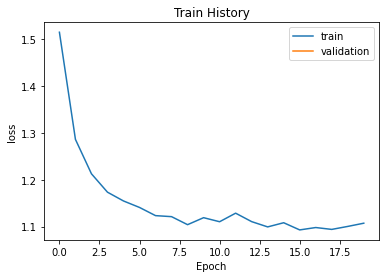

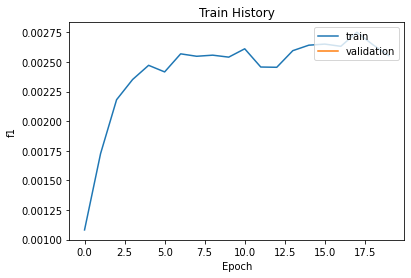

In [23]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history[train])
    plt.plot(train_history[validation])
    plt.title('Train History')
    plt.ylabel(train)        
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc='upper right')
    plt.show()

show_train_history(train_history, 'loss', 'val_loss')
show_train_history(train_history, 'f1', 'val_f1')

In [24]:
_, _ = test_loop(model, test_dataloader, optimizer, True)

Test: 100%|██████████| 245/245 [00:23<00:00, 10.37batch/s, avg_loss=1.3631]


  Average training loss: 1.3631
  Testing Accuracy:     0.0556
  Testing Precision:    0.0015
  Testing Recall:       0.1395
  Testing F1-score:     0.0030
  Each class F1: 0: 0.0013 1: 0.0058 2: 0.0017 
              precision    recall  f1-score   support

           G       0.00      0.06      0.00      1815
           L       0.00      0.20      0.01      2463
           N       0.00      0.13      0.00       684

   micro avg       0.00      0.14      0.00      4962
   macro avg       0.00      0.13      0.00      4962
weighted avg       0.00      0.14      0.00      4962



In [25]:
# torch.save(model, f'./model_finished.pth')